#### Imports

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, make_scorer, f1_score


from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

In [2]:
df = pd.read_csv("../../datasets/fertilizer_recommendation_dataset.csv")

In [3]:
df

,Temperature,Moisture,Rainfall,PH,Nitrogen,Phosphorous,Potassium,Carbon,Soil,Crop,Fertilizer,Remark
0,50.179845,0.725893,205.600816,6.227358,66.701872,76.963560,96.429065,0.496300,Loamy Soil,rice,Compost,Enhances organic matter and improves soil stru...
1,21.633318,0.721958,306.081601,7.173131,71.583316,163.057636,148.128347,1.234242,Loamy Soil,rice,Balanced NPK Fertilizer,"Provides a balanced mix of nitrogen, phosphoru..."
2,23.060964,0.685751,259.336414,7.380793,75.709830,62.091508,80.308971,1.795650,Peaty Soil,rice,Water Retaining Fertilizer,Improves water retention in dry soils. Prefer ...
3,26.241975,0.755095,212.703513,6.883367,78.033687,151.012521,153.005712,1.517556,Loamy Soil,rice,Balanced NPK Fertilizer,"Provides a balanced mix of nitrogen, phosphoru..."
4,21.490157,0.730672,268.786767,7.578760,71.765123,66.257371,97.000886,1.782985,Peaty Soil,rice,Organic Fertilizer,"Enhances fertility naturally, ideal for peaty ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3095,23.486430,0.531191,46.412228,6.733584,56.534283,146.111078,81.389366,1.602913,Neutral Soil,watermelon,Water Retaining Fertilizer,Improves water retention in dry soils. Prefer ...
3096,24.289508,0.736699,63.068103,6.372709,56.358005,49.003277,46.695889,1.473656,Peaty Soil,watermelon,DAP,"Rich in phosphorus, essential for root develop..."
3097,23.945488,0.520513,41.344590,7.051515,55.738905,148.567285,90.057021,1.455045,Neutral Soil,watermelon,Water Retaining Fertilizer,Improves water retention in dry soils. Prefer ...
3098,26.368604,0.547436,33.106012,6.615922,57.711705,96.662953,59.531473,0.614487,Acidic Soil,watermelon,Compost,Enhances organic matter and improves soil stru...


In [4]:
df.Soil.value_counts().to_dict()

{'Acidic Soil': 1519,
 'Peaty Soil': 537,
 'Neutral Soil': 510,
 'Loamy Soil': 489,
 'Alkaline Soil': 45}

#### explore

In [5]:
y = df["Soil"]
x = df.drop(columns=["Soil"])

In [6]:
y_mapping = {
    "Acidic Soil":1,
    "Peaty Soil":2,
    "Neutral Soil":3,
    "Loamy Soil":4,
    "Alkaline Soil":5
}
y = y.map(y_mapping)
y

0       4
1       4
2       2
3       4
4       2
       ..
3095    3
3096    2
3097    3
3098    1
3099    1
Name: Soil, Length: 3100, dtype: int64

In [7]:
objcols = x.select_dtypes("object").columns
objcols

Index(['Crop', 'Fertilizer', 'Remark'], dtype='object')

In [8]:
l_encoder = {}
train_x = x
for col in objcols:
    encoder = LabelEncoder()
    train_x[col] = train_x[col].astype(str)  # Convert all values to string to prevent NaN issues
    train_x[col] = train_x[col].replace('nan', 'Missing')  # Replace NaN with a placeholder
    train_x[col] = encoder.fit_transform(x[col])
    l_encoder[col] = dict(zip(encoder.classes_, range(len(encoder.classes_))))  # Store mapping

In [9]:
train_x

,Temperature,Moisture,Rainfall,PH,Nitrogen,Phosphorous,Potassium,Carbon,Crop,Fertilizer,Remark
0,50.179845,0.725893,205.600816,6.227358,66.701872,76.963560,96.429065,0.496300,28,1,2
1,21.633318,0.721958,306.081601,7.173131,71.583316,163.057636,148.128347,1.234242,28,0,6
2,23.060964,0.685751,259.336414,7.380793,75.709830,62.091508,80.308971,1.795650,28,9,4
3,26.241975,0.755095,212.703513,6.883367,78.033687,151.012521,153.005712,1.517556,28,0,6
4,21.490157,0.730672,268.786767,7.578760,71.765123,66.257371,97.000886,1.782985,28,7,1
...,...,...,...,...,...,...,...,...,...,...,...
3095,23.486430,0.531191,46.412228,6.733584,56.534283,146.111078,81.389366,1.602913,29,9,4
3096,24.289508,0.736699,63.068103,6.372709,56.358005,49.003277,46.695889,1.473656,29,2,8
3097,23.945488,0.520513,41.344590,7.051515,55.738905,148.567285,90.057021,1.455045,29,9,4
3098,26.368604,0.547436,33.106012,6.615922,57.711705,96.662953,59.531473,0.614487,29,1,2


In [10]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_x)
scaled_df = pd.DataFrame(columns=train_x.columns, data=scaled_data)
scaled_df

,Temperature,Moisture,Rainfall,PH,Nitrogen,Phosphorous,Potassium,Carbon,Crop,Fertilizer,Remark
0,2.513859,0.863419,1.226038,-0.159275,0.532500,0.174816,0.756629,-1.400805,1.453444,-1.067074,-1.304921
1,-0.618654,0.836268,2.528624,0.829048,1.011789,2.213998,2.221258,-0.343865,1.453444,-1.381606,0.319842
2,-0.461993,0.586431,1.922641,1.046052,1.416954,-0.177436,0.299950,0.460227,1.453444,1.449179,-0.492539
3,-0.112929,1.064917,1.318114,0.526248,1.645124,1.928704,2.359433,0.061920,1.453444,-1.381606,0.319842
4,-0.634363,0.896398,2.045151,1.252926,1.029640,-0.078766,0.772828,0.442088,1.453444,0.820116,-1.711111
...,...,...,...,...,...,...,...,...,...,...,...
3095,-0.415305,-0.480062,-0.837609,0.369726,-0.465813,1.812610,0.330557,0.184175,1.565248,1.449179,-0.492539
3096,-0.327180,0.937984,-0.621690,-0.007385,-0.483121,-0.487438,-0.652301,-0.000957,1.565248,-0.752542,1.132224
3097,-0.364931,-0.553744,-0.903304,0.701961,-0.543908,1.870787,0.576110,-0.027613,1.565248,1.449179,-0.492539
3098,-0.099034,-0.367969,-1.010105,0.246770,-0.350207,0.641406,-0.288672,-1.231528,1.565248,-1.067074,-1.304921


In [11]:
y

0       4
1       4
2       2
3       4
4       2
       ..
3095    3
3096    2
3097    3
3098    1
3099    1
Name: Soil, Length: 3100, dtype: int64

#### splitting

In [12]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data, y, test_size=0.2, random_state=42)

#### train LR

In [41]:
clf = LogisticRegression()
scorer = make_scorer(f1_score, average='macro')
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=scorer)
print(scores)

[0.58057664 0.62193004 0.52545351 0.65122773 0.60521124]


In [42]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

<Axes: >

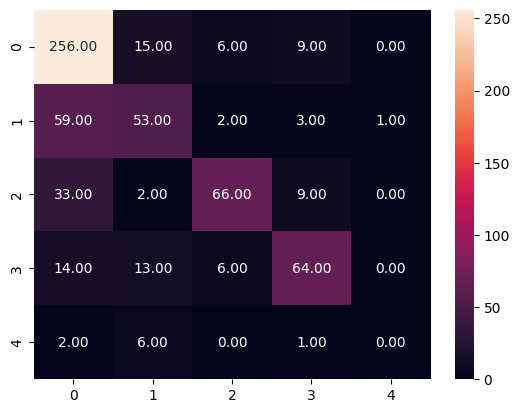

In [43]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt=".2f")

In [44]:
y.value_counts()

Soil
1    1519
2     537
3     510
4     489
5      45
Name: count, dtype: int64

#### CNN

In [12]:
scaled_df, y

(      Temperature  Moisture  Rainfall        PH  Nitrogen  Phosphorous  \
 0        2.513859  0.863419  1.226038 -0.159275  0.532500     0.174816   
 1       -0.618654  0.836268  2.528624  0.829048  1.011789     2.213998   
 2       -0.461993  0.586431  1.922641  1.046052  1.416954    -0.177436   
 3       -0.112929  1.064917  1.318114  0.526248  1.645124     1.928704   
 4       -0.634363  0.896398  2.045151  1.252926  1.029640    -0.078766   
 ...           ...       ...       ...       ...       ...          ...   
 3095    -0.415305 -0.480062 -0.837609  0.369726 -0.465813     1.812610   
 3096    -0.327180  0.937984 -0.621690 -0.007385 -0.483121    -0.487438   
 3097    -0.364931 -0.553744 -0.903304  0.701961 -0.543908     1.870787   
 3098    -0.099034 -0.367969 -1.010105  0.246770 -0.350207     0.641406   
 3099     0.043853 -0.290097 -0.782413  2.558819 -0.128709     0.218005   
 
       Potassium    Carbon      Crop  Fertilizer    Remark  
 0      0.756629 -1.400805  1.453444 

In [13]:
scaled_df.shape, y.unique()

((3100, 11), array([4, 2, 1, 3, 5]))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data, y, test_size=0.2, random_state=42)

In [15]:
X_train.shape

(2480, 11)

In [16]:
# Example input shape
input_shape = (scaled_df.shape[1],)
num_classes = len(list(y.unique()))

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=input_shape),
    Dropout(0.3),
    # Dense(64, activation='relu'),
    # Dropout(0.3),
    Dense(num_classes, activation='softmax')  # Softmax for multiclass classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # If y labels are integers (not one-hot)
    metrics=['accuracy']
)

# Example:
# X_train.shape = (num_samples, 10)
# y_train.shape = (num_samples,) with values like [0,1,2,3]

In [ ]:
# Fit the model
model.fit(X_train, y_train, epochs=3, batch_size=16, validation_split=0.2)

Epoch 1/3


In [ ]:
model.predict(X_test)

In [ ]:
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import GridSearchCV

# def create_model(optimizer='adam', dropout_rate=0.3):
#     model = Sequential([
#         Dense(64, activation='relu', input_shape=(10,)),
#         Dropout(dropout_rate),
#         Dense(64, activation='relu'),
#         Dense(4, activation='softmax')
#     ])
#     model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model

# model = KerasClassifier(build_fn=create_model, verbose=0)

# param_grid = {
#     'batch_size': [32, 64],
#     'epochs': [20, 30],
#     'optimizer': ['adam', 'rmsprop'],
#     'dropout_rate': [0.3, 0.5]
# }

# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
# grid_result = grid.fit(X_train, y_train)

#### Up sampling down sampling

In [33]:
df

,Temperature,Moisture,Rainfall,PH,Nitrogen,Phosphorous,Potassium,Carbon,Soil,Crop,Fertilizer,Remark
0,50.179845,0.725893,205.600816,6.227358,66.701872,76.963560,96.429065,0.496300,Loamy Soil,rice,Compost,Enhances organic matter and improves soil stru...
1,21.633318,0.721958,306.081601,7.173131,71.583316,163.057636,148.128347,1.234242,Loamy Soil,rice,Balanced NPK Fertilizer,"Provides a balanced mix of nitrogen, phosphoru..."
2,23.060964,0.685751,259.336414,7.380793,75.709830,62.091508,80.308971,1.795650,Peaty Soil,rice,Water Retaining Fertilizer,Improves water retention in dry soils. Prefer ...
3,26.241975,0.755095,212.703513,6.883367,78.033687,151.012521,153.005712,1.517556,Loamy Soil,rice,Balanced NPK Fertilizer,"Provides a balanced mix of nitrogen, phosphoru..."
4,21.490157,0.730672,268.786767,7.578760,71.765123,66.257371,97.000886,1.782985,Peaty Soil,rice,Organic Fertilizer,"Enhances fertility naturally, ideal for peaty ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3095,23.486430,0.531191,46.412228,6.733584,56.534283,146.111078,81.389366,1.602913,Neutral Soil,watermelon,Water Retaining Fertilizer,Improves water retention in dry soils. Prefer ...
3096,24.289508,0.736699,63.068103,6.372709,56.358005,49.003277,46.695889,1.473656,Peaty Soil,watermelon,DAP,"Rich in phosphorus, essential for root develop..."
3097,23.945488,0.520513,41.344590,7.051515,55.738905,148.567285,90.057021,1.455045,Neutral Soil,watermelon,Water Retaining Fertilizer,Improves water retention in dry soils. Prefer ...
3098,26.368604,0.547436,33.106012,6.615922,57.711705,96.662953,59.531473,0.614487,Acidic Soil,watermelon,Compost,Enhances organic matter and improves soil stru...


In [24]:
train_x.shape

(3100, 11)

In [ ]:
y.value_counts()

Soil
1    1519
2     537
3     510
4     489
5      45
Name: count, dtype: int64

In [21]:
from imblearn.combine import SMOTEENN

In [26]:
sme = SMOTEENN(random_state=42, sampling_strategy="all")
X_res, y_res = sme.fit_resample(train_x, y)

In [27]:
X_res.shape

(5146, 11)

In [28]:
y_res.value_counts()

Soil
5    1466
4    1123
3    1114
2     941
1     502
Name: count, dtype: int64

In [34]:
df_x, df_y = df.drop(columns=["Soil"]), df["Soil"]

In [37]:
df_x.shape, df_y

((3100, 11),
 0         Loamy Soil
 1         Loamy Soil
 2         Peaty Soil
 3         Loamy Soil
 4         Peaty Soil
             ...     
 3095    Neutral Soil
 3096      Peaty Soil
 3097    Neutral Soil
 3098     Acidic Soil
 3099     Acidic Soil
 Name: Soil, Length: 3100, dtype: object)

In [39]:
from imblearn.over_sampling import SMOTENC
import numpy as np

# Specify which columns are categorical (by index)
categorical_features = [8, 9, 10]  # Example: first and third columns are categorical

# Initialize SMOTENC
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)

# Apply resampling
X_resampled, y_resampled = smote_nc.fit_resample(df_x, df_y)

In [40]:
X_resampled

,Temperature,Moisture,Rainfall,PH,Nitrogen,Phosphorous,Potassium,Carbon,Crop,Fertilizer,Remark
0,50.179845,0.725893,205.600816,6.227358,66.701872,76.963560,96.429065,0.496300,rice,Compost,Enhances organic matter and improves soil stru...
1,21.633318,0.721958,306.081601,7.173131,71.583316,163.057636,148.128347,1.234242,rice,Balanced NPK Fertilizer,"Provides a balanced mix of nitrogen, phosphoru..."
2,23.060964,0.685751,259.336414,7.380793,75.709830,62.091508,80.308971,1.795650,rice,Water Retaining Fertilizer,Improves water retention in dry soils. Prefer ...
3,26.241975,0.755095,212.703513,6.883367,78.033687,151.012521,153.005712,1.517556,rice,Balanced NPK Fertilizer,"Provides a balanced mix of nitrogen, phosphoru..."
4,21.490157,0.730672,268.786767,7.578760,71.765123,66.257371,97.000886,1.782985,rice,Organic Fertilizer,"Enhances fertility naturally, ideal for peaty ..."
...,...,...,...,...,...,...,...,...,...,...,...
7590,19.586739,0.788815,106.488193,5.219182,49.914054,55.006358,52.966099,1.381844,orange,Urea,Improves water retention in dry soils. Prefer ...
7591,23.723000,0.555181,117.020920,7.726854,59.821289,62.603811,62.143913,2.001871,pomegranate,Water Retaining Fertilizer,Improves water retention in dry soils. Prefer ...
7592,29.090512,0.706243,157.839834,8.146678,66.543422,52.910720,53.010724,1.605395,Sugarcane,Gypsum,"Corrects alkaline soil, adds calcium and sulfu..."
7593,24.739087,0.820407,353.471838,5.540966,89.929735,39.192476,73.609339,1.435734,Rubber,DAP,"Rich in phosphorus, essential for root develop..."
